In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Union, Tuple, Iterable, Optional, Any
from tqdm import tqdm
from einops import rearrange

In [2]:
@dataclass
class Disease:
    beta: float
    gamma: float
    delta: float

In [3]:
def vectorized_multinomial(n: np.ndarray, ps: np.ndarray):
    """
    len(n) == ps.shape[1] is the number of multinomials to be carried out in parallel (batchsize)
    ps.shape[0] is the number of possibilities (number of different possible outcomes of the random process) unless the sum of probabilities is smaller than one, in which case another row is added for the remaining probability: so [0.1,0.2] -> [0.1,0.2,0.7]
    for each calculation, ps[:,i] is an array of probabilities to calculate multinomials for
    The last dimension of ps is looped over so the calculation is fast if there are many more calculations to do than probabilities per calculation
    out: shape(possibilities, batchsize)
    """
    assert len(n.shape) == 1, f"Invalid n.shape: {n.shape}"
    assert len(ps.shape) == 2, f"Invalid ps.shape: {ps.shape}"
    assert ps.shape[1] == n.shape[0], f"Incompatible shapes: {ps.shape}, {n.shape}"
    assert all(np.abs(ps.sum(axis = 0) - 1) < 1e-12), f"Invalid sum of probabilities: {ps.sum(axis = 0)}"
    if ps[:,0].sum() < 1-1e12:
        print(f'Warning: sum of probabilities is {ps[:,0].sum()}')
        new_ps = np.zeros((ps.shape[0]+1, ps.shape[1]))
        new_ps[:-1] = ps
        new_ps[-1] = 1 - ps.sum(axis = 0)
        ps = new_ps
    ps = np.maximum(ps, 1e-14)
    assert all(np.abs(ps.sum(axis = 0) - 1) < 1e-12), f"Invalid sum of probabilities: {ps.sum(axis = 0)}"
    out = np.zeros((ps.shape[0], len(n)))
    for i in range(ps.shape[0]):
        prob = ps[i] / ps[i:].sum(axis = 0)
        sample = np.random.binomial(n, prob)
        n -= sample
        out[i] = sample
    return out

def vectorized_select(choices: np.ndarray, n: int):
    #Currently unused
    """
    choices: shape (options, batchsize)
    n is the number of samples to take
    out: shape (options, batchsize)
    Big downside: there is a for loop over the population in each batch: this is bad if we want to work with populations that are millions of people!!!
    """
    out = np.zeros_like(choices)
    for i in range(n):
        probs = choices / choices.sum(axis = 0, keepdims=True)
        selection = vectorized_multinomial(np.ones(choices.shape[1]),probs)
        choices -= selection
        out += selection
    return out



In [4]:

class FrequentFlierCity:
    def __init__(self, N0: int = 10**6,
                 frequent_flier_frac: float = 1/11,
                 p_ff: Optional[float] = None,
                 flying_LR: Optional[float] = None,
                 mixing_LR:float = 5,
                #  I0: int = 0,
                 stochastic: bool = True
                 ):
        """frequent_flier_frac: the fraction of the population that is in the frequent flier class of people who travel all the time
        p_ff: the fraction of people who travel who are frequent_fliers
        flying_LR: the amount of times more likely it is that a given frequent flier gets on a particular plane than a given normal person
        mixing_LR: the amount of times more likely it is that the person a frequent flyer came into contact with is a given different frequent flyer than a given normal person
        I0: the initial number of infected people
        """
        self.N0 = {'normal': int(N0 * (1 - frequent_flier_frac)),
                  'frequent_flyer': int(N0 * frequent_flier_frac)}
        self.frequent_flier_frac = frequent_flier_frac

        if (p_ff is None) and (flying_LR is None):
            flying_LR = 10
        assert (p_ff is None) != (flying_LR is None), "Specify exactly one of p_ff OR flying_LR!"
        if flying_LR is not None:
            self.flying_LR = flying_LR
            self.p_ff = flying_LR * frequent_flier_frac/ (flying_LR * frequent_flier_frac + (1 - frequent_flier_frac))
        if p_ff is not None:
            self.p_ff = p_ff
            self.flying_LR = (p_ff / frequent_flier_frac) / ((1-p_ff) / (1 - frequent_flier_frac))

        self.mixing_LR = mixing_LR
        self.stochastic = stochastic
        # self.I0 = I0
        self.compartments = ['S','E','I','R']
        self.groups = ['normal', 'frequent_flyer']

    def reset_parameters(self, I0: int = 0, n_sims: int = 1, simulation_steps: int = 100, include_flight_data = False):
        """
        Sets self.data to a dict of dicts, containing an array of zeros of size (n_sims, timesteps) for each compartment in the city
        The only values which aren't zero are the initial value of I which is I0 and the initial value of S which is N-I0
        The default value of I0 is the value set in the class initialization, but can be overridden
        """
        # if I0 is None:
        #     I0 = self.I0
        self.I0 = I0
        I_n = np.random.binomial(I0, 1-self.frequent_flier_frac, n_sims)
        # else:
        #     I_n = I0 * (1-self.frequent_flyermen_frac)
        I_b = I0 - I_n
        self.data = {}
        for group in self.groups:
            self.data[group] = {}
            for compartment in self.compartments:
                self.data[group][compartment] = np.zeros((n_sims, simulation_steps),np.int64)
        self.data['normal']['I'][:,0] = I_n
        self.data['frequent_flyer']['I'][:,0] = I_b

        self.data['normal']['S'][:,0] = np.ones(n_sims) * self.N0['normal'] - I_n
        self.data['frequent_flyer']['S'][:,0] = np.ones(n_sims) * self.N0['frequent_flyer'] - I_b

        if include_flight_data:
            self.arrivals = {}
            self.departures = {}
            for group in self.groups:
                self.arrivals[group] = {}
                self.departures[group] = {}
                for compartment in self.compartments:
                    self.arrivals[group][compartment] = np.zeros((n_sims, simulation_steps),np.int64)
                    self.departures[group][compartment] = np.zeros((n_sims, simulation_steps),np.int64)
    
    def multiple_sims(self, delta_t: float, epidemic_time: Union[int,float], disease: Disease, I0: int = 0, n_sims: int = 100):
        self.n_sims = n_sims
        self.delta_t = delta_t
        self.epidemic_time = epidemic_time
        p_recovery = 1 - np.exp( - delta_t * disease.gamma)
        p_infectious = 1 - np.exp( - delta_t * disease.delta)
        timesteps = int(epidemic_time // delta_t)
        self.times = np.linspace(0, epidemic_time, timesteps+1)
        self.reset_parameters(I0, n_sims, timesteps+1)
        for timestep in tqdm(range(timesteps)):
            self.step_internal(disease.beta,
                      delta_t,
                      p_infectious,
                      p_recovery,
                      timestep)

    def step_internal(self,
                      beta:float,
                      delta_t: float,
                      p_infectious: float,
                      p_recovery: float,
                      simulation_step: int):
        new_S = {}
        new_E = {}
        new_I = {}
        new_R = {}
        N = {}

        for group in self.groups:
            N[group] = sum([self.data[group][compartment][:,simulation_step] for compartment in self.compartments])
        for i, group in enumerate(self.groups):
            modified_I = self.mixing_LR * self.data[group]['I'][:,simulation_step] + self.data[self.groups[not i]]['I'][:,simulation_step]
            modified_N = self.mixing_LR * N[group] + N[self.groups[not i]]
            exposure_rate = beta * modified_I / modified_N
            p_exposure = 1 - np.exp(- delta_t * exposure_rate)
            n_exposed = np.random.binomial(self.data[group]['S'][:,simulation_step], p_exposure)
            n_infectious = np.random.binomial(self.data[group]['E'][:,simulation_step], p_infectious)
            n_recovered = np.random.binomial(self.data[group]['I'][:,simulation_step], p_recovery)
            new_S[group] = self.data[group]['S'][:,simulation_step] - n_exposed
            new_E[group] = self.data[group]['E'][:,simulation_step] + n_exposed - n_infectious
            new_I[group] = self.data[group]['I'][:,simulation_step] + n_infectious - n_recovered
            new_R[group] = self.data[group]['R'][:,simulation_step] + n_recovered
            self.data[group]['S'][:,simulation_step+1] = new_S[group]
            self.data[group]['E'][:,simulation_step+1] = new_E[group]
            self.data[group]['I'][:,simulation_step+1] = new_I[group]
            self.data[group]['R'][:,simulation_step+1] = new_R[group]
        
        #Mixing between normal people and frequent fliers
        # for i, group in enumerate(self.groups):
        #     #TO DO: this line isn't quite right. Need to think a bit harder about which I and N to use
        #     exposure_rate = self.mixing_LR * beta * new_I[self.groups[not i]] / (N[self.groups[not i]])
            
        #     p_exposure = 1 - np.exp(- time_interval * exposure_rate)
        #     n_exposed = np.random.binomial(new_S[group], p_exposure)
        #     new_S[group] -= n_exposed
        #     new_E[group] += n_exposed

    def daily_flight_data(self, delta_t, moving_average = False):

        self.daily_arrivals = {}
        self.daily_departures = {}
        window = int(1/delta_t)
        for group in self.groups:
            self.daily_arrivals[group] = {}
            self.daily_departures[group] = {}
            for compartment in self.compartments:
                arrivals = self.arrivals[group][compartment]
                n_sims, simulation_steps = arrivals.shape
                self.daily_arrivals[group][compartment] = arrivals.reshape((n_sims, simulation_steps//window, window)).sum(axis = -1)
                #if moving_average
                    # arrivals = arrivals.lib.stride_tricks.as_strided((len(arrivals) - window + 1, window),(-1,1))
                departures = self.departures[group][compartment]
                self.daily_departures[group][compartment] = departures.reshape((n_sims, simulation_steps//window, window)).sum(axis = -1)

    def select_travellers_old(self, mixnumbers: Union[int,np.ndarray], n_sims: int, simulation_step: int):
        if isinstance(mixnumbers,int):
            mixnumbers = mixnumbers * np.ones(n_sims, dtype = np.int64)
        N = []
        for group in self.groups:
            N.append(sum([self.data[group][compartment][:,simulation_step+1] for compartment in self.compartments]))
        all_travellers = {'frequent_flyer': np.random.binomial(mixnumbers, self.p_ff)}
        all_travellers['normal'] = mixnumbers - all_travellers['frequent_flyer']
        travellers = np.zeros((2,4,n_sims), dtype = np.int64)
        for i,group in enumerate(self.groups):
            allocation_probs = []
            for compartment in self.compartments:
                allocation_probs.append(self.data[group][compartment][:,simulation_step+1] / N[i])
                if np.any(N == 0):
                    print('Warning: N == 0')
            allocation_probs = np.array(allocation_probs)
            # print(allocation_probs)
            travellers[i] = vectorized_multinomial(all_travellers[group], allocation_probs)
            
            #This bit is to make sure you never have more travellers than people
            valid = True
            for j, compartment in enumerate(self.compartments):
                if np.any(travellers[i,j] > self.data[group][compartment][:,simulation_step+1]):
                    valid = False
            while not valid:
                travellers[i] = vectorized_multinomial(all_travellers[group], allocation_probs)
                valid = True
                for j, compartment in enumerate(self.compartments):
                    if np.any(travellers[i,j] > self.data[group][compartment][:,simulation_step+1]):
                        valid = False
        return travellers

    def select_travellers(self, daily_mixnumber: int, n_sims: int, simulation_step: int, delta_t: float):
        "Selects travellers based on a constant rate per person. This means number of travellers isn't preserved so the rate is modified to provide a force that pushes things back to the baseline population"
        N = []
        fractions = [1 - self.p_ff, self.p_ff]
        for group in self.groups:
            N.append(sum([self.data[group][compartment][:,simulation_step+1] for compartment in self.compartments]))
        
        travellers = np.zeros((2,4,n_sims), dtype = np.int64)
        for i,group in enumerate(self.groups):
            modified_mixnumber = daily_mixnumber * N[i] / self.N0[group]
            p_travel = 1 - np.exp(- delta_t * modified_mixnumber * fractions[i] / N[i])
            for j,compartment in enumerate(self.compartments):
                travellers[i,j] = np.random.binomial(self.data[group][compartment][:,simulation_step+1], p_travel)
        return travellers
    
    def make_data_array(self):
        "Converts the dictionary of dictionary of data for each group and compartment into a single big array to ease data manipulation"
        include_flight_data = 'arrivals' in dir(self)
        self.data_array: np.ndarray = np.zeros((2,4,self.n_sims,len(self.times)),dtype = np.int64)
        if include_flight_data:
            self.arrivals_array: np.ndarray = np.zeros((2,4,self.n_sims,len(self.times)),dtype = np.int64)
            self.departures_array: np.ndarray = np.zeros((2,4,self.n_sims,len(self.times)),dtype = np.int64)
            n_days = self.daily_arrivals['normal']['I'].shape[-1]
            self.daily_arrivals_array: np.ndarray = np.zeros((2,4,self.n_sims, n_days),dtype = np.int64)
            self.daily_departures_array: np.ndarray = np.zeros((2,4,self.n_sims, n_days),dtype = np.int64)
        for i, group in enumerate(self.groups):
            for j, compartment in enumerate(self.compartments):
                self.data_array[i,j] = self.data[group][compartment]
                if include_flight_data:
                    self.arrivals_array[i,j] = self.arrivals[group][compartment]
                    self.departures_array[i,j] = self.departures[group][compartment]
                    self.daily_arrivals_array[i,j] = self.daily_arrivals[group][compartment]
                    self.daily_departures_array[i,j] = self.daily_departures[group][compartment]

    def plot_sims(self,
                  times: Optional[np.ndarray] = None,
                  cityname: Union[int,str] = 0, 
                  shift_index: Optional[np.ndarray] = None,
                  separate_groups: bool = False):
        include_flight_data = 'arrivals' in dir(self)
        subplots = 2 if separate_groups else 1
        if include_flight_data:
            fig, axs = plt.subplots(3,subplots, figsize = (20,30))
            axs = np.array(axs)
        else:
            fig, axs = plt.subplots(1,subplots, figsize = (20,10))
            axs = np.expand_dims(np.array(axs),0)
        if times is None:
            times = self.times
        if shift_index is None:
            shift = np.zeros((self.n_sims,1))
        else:
            shift = times[shift_index].reshape((self.n_sims,1))
        # assert shift.shape == (self.n_sims,1), "Wrong shift shape"
        days = np.array(range(int(max(times))), dtype = np.float64)
        
        times = times - shift + shift.mean()
        days = days - shift + shift.mean()
        cols = ['green', 'orange', 'red', 'blue']
        labels = ['Whole City', 'Arrivals', 'Departures']
        if separate_groups:
            for i, group in enumerate(self.groups):
                for j,compartment in tqdm(enumerate(self.compartments)):
                    axs[0,i].plot(times[0],
                                self.data[group][compartment][0],
                                label = compartment,
                                color = cols[j])
                    if include_flight_data:
                        axs[1,i].plot(days[0],  
                                    self.daily_arrivals[group][compartment][0],
                                    label = compartment,
                                    color = cols[j])
                        axs[2,i].plot(days[0],
                                    self.daily_departures[group][compartment][0],
                                    label = compartment,
                                    color = cols[j])
                    for k,datum in enumerate(self.data[group][compartment][1:]):
                        axs[0,i].plot(times[k+1], datum, color = cols[j])
                    if include_flight_data:
                        for k, (arrival, departure) in enumerate(zip(self.daily_arrivals[group][compartment][1:],self.daily_departures[group][compartment][1:])):
                            axs[1,i].plot(days[k+1], arrival, color = cols[j])
                            axs[2,i].plot(days[k+1], departure, color = cols[j])
                num_subplots = axs.shape[0]
                for j in range(num_subplots):
                    axs[j,i].legend()
                    axs[j,i].set_title(f"City {cityname}, {group}: {labels[j]}")
        else:
            for j, compartment in tqdm(enumerate(self.compartments)):
                axs[0].plot(times[0],
                            self.data_array[:,j,0].sum(axis = 0),
                            label = compartment,
                            color = cols[j])
                if include_flight_data:
                    axs[1].plot(days[0],
                                self.daily_arrivals_array[:,j,0].sum(axis = 0),
                                label = compartment,
                                color = cols[j])
                    axs[2].plot(days[0],
                                self.daily_departures_array[:,j,0].sum(axis = 0),
                                label = compartment,
                                color = cols[j])
                for k,datum in enumerate(self.data_array[:,j,1:].sum(axis = 0)):
                    axs[0].plot(times[k+1], datum, color = cols[j])
                    if include_flight_data:
                        for k, (arrival, departure) in enumerate(zip(self.daily_arrivals_array[:,j,1:].sum(axis = 0),self.daily_departures_array[:,j,1:].sum(axis = 0))):
                            axs[1].plot(days[k+1], arrival, color = cols[j])
                            axs[2].plot(days[k+1], departure, color = cols[j])
            num_subplots = axs.shape[0]
            for j in range(num_subplots):
                axs[j].legend()
                axs[j].set_title(f"City {cityname}: {labels[j]}")
        # else:
        #     for i, group in enumerate(self.groups):
        #         for j,compartment in enumerate(self.compartments):
        #             axs[i].plot(x_axis, self.data[group][compartment][0], label = compartment, color = cols[j])
        #             for datum in tqdm(self.data[group][compartment][1:]):
        #                 axs[i].plot(x_axis, datum, color = cols[j])
        #         axs[i].legend()
        #         axs[i].set_title(f"City {cityname}, {group}")
        fig.show()
    
    def infections_at_time(self, time_indexes: Optional[np.ndarray] = None, time: Optional[np.ndarray] = None, included_compartments: str = 'EIR'):
        """
        Returns the number of normal, infectious, and total people who have left the susceptible compartment by time t
        times: size (n_sims) the (different) time at which to evaluate number who have been exposed for each sim
        """
        assert (time is not None) != (time_indexes is not None), "Exactly one of time_indexes and times should be specified"
        if time_indexes is None:
            assert time is not None
            time_indexes = self.times.searchsorted(time)
        assert len(time_indexes) == self.n_sims, "len(times) must be n_sims"
        out = {}
        values = np.zeros((self.n_sims,2,4))
        to_include = [l for l in included_compartments]
        for i,group in enumerate(self.groups):
            out[group] = np.zeros(self.n_sims)
            for j, compartment in enumerate(self.compartments):
                # values[:,i,j] = self.data[group][compartment][np.array(range(self.n_sims)),time_indexes]
                if compartment in to_include:
                    out[group] += self.data[group][compartment][np.array(range(self.n_sims)),time_indexes]
            # out[group] = values[:,i].sum(axis = -1) - values[:,i,0]
            assert out[group].shape == (self.n_sims,), "Logical Error Somewhere!"
        out['total'] = sum([out[group] for group in self.groups])
        return out


In [5]:
class TravelNetwork:
    """Assumes a fixed number of daily travellers from a network encoded by a mixmatrix"""
    def __init__(self, cities: list[FrequentFlierCity], mixmatrix: np.ndarray, I0s: Optional[list[int]] = None):
        self.cities = cities
        self.mixmatrix = mixmatrix.astype(np.int64)
        assert np.all(mixmatrix == mixmatrix.T), "mixmatrix must be symmetrical!"
        assert np.trace(mixmatrix) == 0, "mixmatrix must be traceless!"
        self.reset_parameters(I0s)
    
    def reset_parameters(self, I0s: Optional[list[int]] = None, n_sims = 1, simulation_steps:int = 100):
        for i,city in enumerate(self.cities):
            if I0s is None:
                city.reset_parameters(n_sims = n_sims,
                                      simulation_steps = simulation_steps,
                                      include_flight_data=True)
            else:
                city.reset_parameters(I0 = I0s[i],
                                      n_sims = n_sims,
                                      simulation_steps = simulation_steps,
                                      include_flight_data=True)
            
    def step(self,
             beta:float,
             delta_t: float,
             p_infectious: float,
             p_recovery: float,
             simulation_step: int,
             n_sims: int):
        changes = {}
        arrivals = {}
        departures = {}
        for city in self.cities:
            #First, do the interal spread within each city
            city.step_internal(beta,
                                    delta_t,
                                    p_infectious,
                                    p_recovery,
                                    simulation_step)
            #Initialize changes 
            changes[city] = np.zeros((2,4,n_sims), dtype = np.int64)
            arrivals[city] = np.zeros((2,4,n_sims), dtype = np.int64)
            departures[city] = np.zeros((2,4,n_sims), dtype = np.int64)

        for i, com1 in enumerate(self.cities):
            for j, com2 in enumerate(self.cities):
                if j > i:
                    if self.independent_flyers:
                        mix = self.mixmatrix[i,j]
                        non_zero = mix != 0
                    else:
                        if self.vary_m_by_sim:
                            mix = np.random.binomial(self.mixmatrix[i,j],delta_t, n_sims)
                            non_zero = np.any(mix != 0)
                        else:
                            mix = np.random.binomial(self.mixmatrix[i,j],delta_t)
                            non_zero = mix != 0
                    if non_zero:
                        #Take mixmatrix_ij people from city i and j and swap them
                        if self.independent_flyers:
                            mix = int(mix)
                            assert isinstance(mix, int)
                            travel_12 = com1.select_travellers(mix, n_sims, simulation_step, delta_t)
                            travel_21 = com2.select_travellers(mix, n_sims, simulation_step, delta_t)
                        else:
                            travel_12 = com1.select_travellers_old(mix, n_sims, simulation_step)
                            travel_21 = com2.select_travellers_old(mix, n_sims, simulation_step)
                        changes[com1] = travel_21 - travel_12
                        changes[com2] = travel_12 - travel_21
                        # comm1,comm2 = com1,com2
                        # if np.any(np.logical_or(travel_12 < 0,travel_21 < 0)):
                        #     print('Warning: negative travellers')
                        for i,group in enumerate(com1.groups):
                            for j, compartment in enumerate(com1.compartments):
                                com1.data[group][compartment][:,simulation_step+1] += changes[com1][i,j]
                                com2.data[group][compartment][:,simulation_step+1] += changes[com2][i,j]
                        #         if np.any(com1.data[group][compartment][:,timestep+1] + changes[com1][i,j] < 0):
                        #             print(f'Warning: Comm1 below zero at {group}, {compartment}')
                        #             print(com1.data[group][compartment][:,timestep+1])
                        #             print(travel_12[i,j])
                        #             print(com1.data[group][compartment][:,timestep+1] + changes[com1][i,j])
                        #         if np.any(com2.data[group][compartment][:,timestep+1] + changes[com2][i,j] < 0):
                        #             print(f'Warning: Comm2 below zero at {group}, {compartment}')
                        #             print(com2.data[group][compartment][:,timestep+1])
                        #             print(travel_21)
                        #             print(com2.data[group][compartment][:,timestep+1] + changes[com2][i,j])
                        arrivals[com1] += travel_21
                        arrivals[com2] += travel_12
                        departures[com1] += travel_12
                        departures[com2] += travel_21
        for city in self.cities:
            for i,group in enumerate(city.groups):
                for j, compartment in enumerate(city.compartments):
                    # city.data[group][compartment][:,timestep+1] += changes[city][i,j]
                    city.arrivals[group][compartment][:,simulation_step+1] = arrivals[city][i,j]
                    city.departures[group][compartment][:,simulation_step+1] = departures[city][i,j]
                    # if np.any(city.data[group][compartment][:,timestep+1] < 0):
                    #     print(f'WARNING: population below zero in {group} {compartment}')
                    #     print(travel_12)
                    #     print(travel_21)
                    #     vals1 = comm1.data[group][compartment][:,timestep+1]
                    #     vals2 = comm2.data[group][compartment][:,timestep+1]
                    #     print(vals1, vals1 - changes[comm1][0,1])
                    #     print(vals2, vals2 - changes[comm2][0,1])
                    
    def multiple_sims(self,
                      delta_t: float,
                      epidemic_time: Union[int,float],
                      disease: Disease,
                      n_sims: int = 100,
                      I0s: Optional[Union[int,list[int]]] = None,
                      vary_m_by_sim: bool = True,
                      independent_flyers: bool = True):
        if I0s is None:
            I0s = [round(sum([self.cities[0].N0[group] for group in self.cities[0].groups])/1000)]
            I0s += [0] * (len(self.cities) - 1)
        elif isinstance(I0s, int):
            I0s = [I0s] + [0] * (len(self.cities) - 1)
        self.start_city = self.cities[[I0 != 0 for I0 in I0s].index(True)]
        p_recovery = 1 - np.exp( - delta_t * disease.gamma)
        p_infectious = 1 - np.exp( - delta_t * disease.delta)
        simulation_steps = int(epidemic_time // delta_t)
        self.reset_parameters(I0s, n_sims, simulation_steps+1)
        self.times = np.linspace(0, epidemic_time, simulation_steps+1)
        self.vary_m_by_sim = vary_m_by_sim
        self.independent_flyers = independent_flyers
        self.n_sims = n_sims
        for city in self.cities:
            city.delta_t = delta_t
            city.n_sims = n_sims
            city.epidemic_time = epidemic_time
            city.times = self.times
        for simulation_step in tqdm(range(simulation_steps)):
            self.step(disease.beta,
                      delta_t,
                      p_infectious,
                      p_recovery,
                      simulation_step,
                      n_sims)
        for city in self.cities:
            city.daily_flight_data(delta_t)
            city.make_data_array()

    def plot_sims(self, to_shift: bool = True, included: Optional[list[int]] = None, separate_groups: bool = True):
        if included is None:
            included = list(range(len(self.cities)))
        shift_index = None
        if to_shift:
            shift_index = self.start_city.data['normal']['I'].argmax(axis = 1)
            # shift = shift_index * self.start_city.delta_t
        for i, city in enumerate(self.cities):
            if i in included:
                print(f"CITY {i}:")
                city.plot_sims(times = self.times, cityname=i, shift_index = shift_index, separate_groups=separate_groups)
                print('\n')
    
    def __str__(self):
        out = ''
        for i, city in enumerate(self.cities):
            out += f'\nCity {i}:\n'
            for group in ['normal', 'frequent_flyer']:
                out += f'  {group} people:\n'
                for compartment in ['S','E','I','R']:
                    out += f'    {compartment}:' + str(city.data[group][compartment][-1]) + '\n'
        out += 'Matrix of Interactions:\n' + str(self.mixmatrix)
        return out

    # def infections_after_threshold:
        

In [6]:
measles = Disease(1.5, 1/8,1/10)

In [7]:
city1 = FrequentFlierCity(N0 = 10**6, frequent_flier_frac = 0.1, flying_LR=20, mixing_LR=2)
city2 = FrequentFlierCity(N0 = 10**6, frequent_flier_frac = 0.1, flying_LR=20, mixing_LR=2)
mixmatrix = 1000 * (1 - np.identity(2))
testnetwork = TravelNetwork([city1,city2],mixmatrix)
testnetwork.multiple_sims(delta_t = 0.05,
                          epidemic_time=100,
                          disease = measles,
                          I0s = [5,0],
                          n_sims=40)



100%|██████████| 1999/1999 [00:01<00:00, 1560.32it/s]


CITY 0:


4it [00:03,  1.08it/s]
/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_28286/2788180571.py:295: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()




CITY 1:


4it [00:05,  1.28s/it]
/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_28286/2788180571.py:295: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


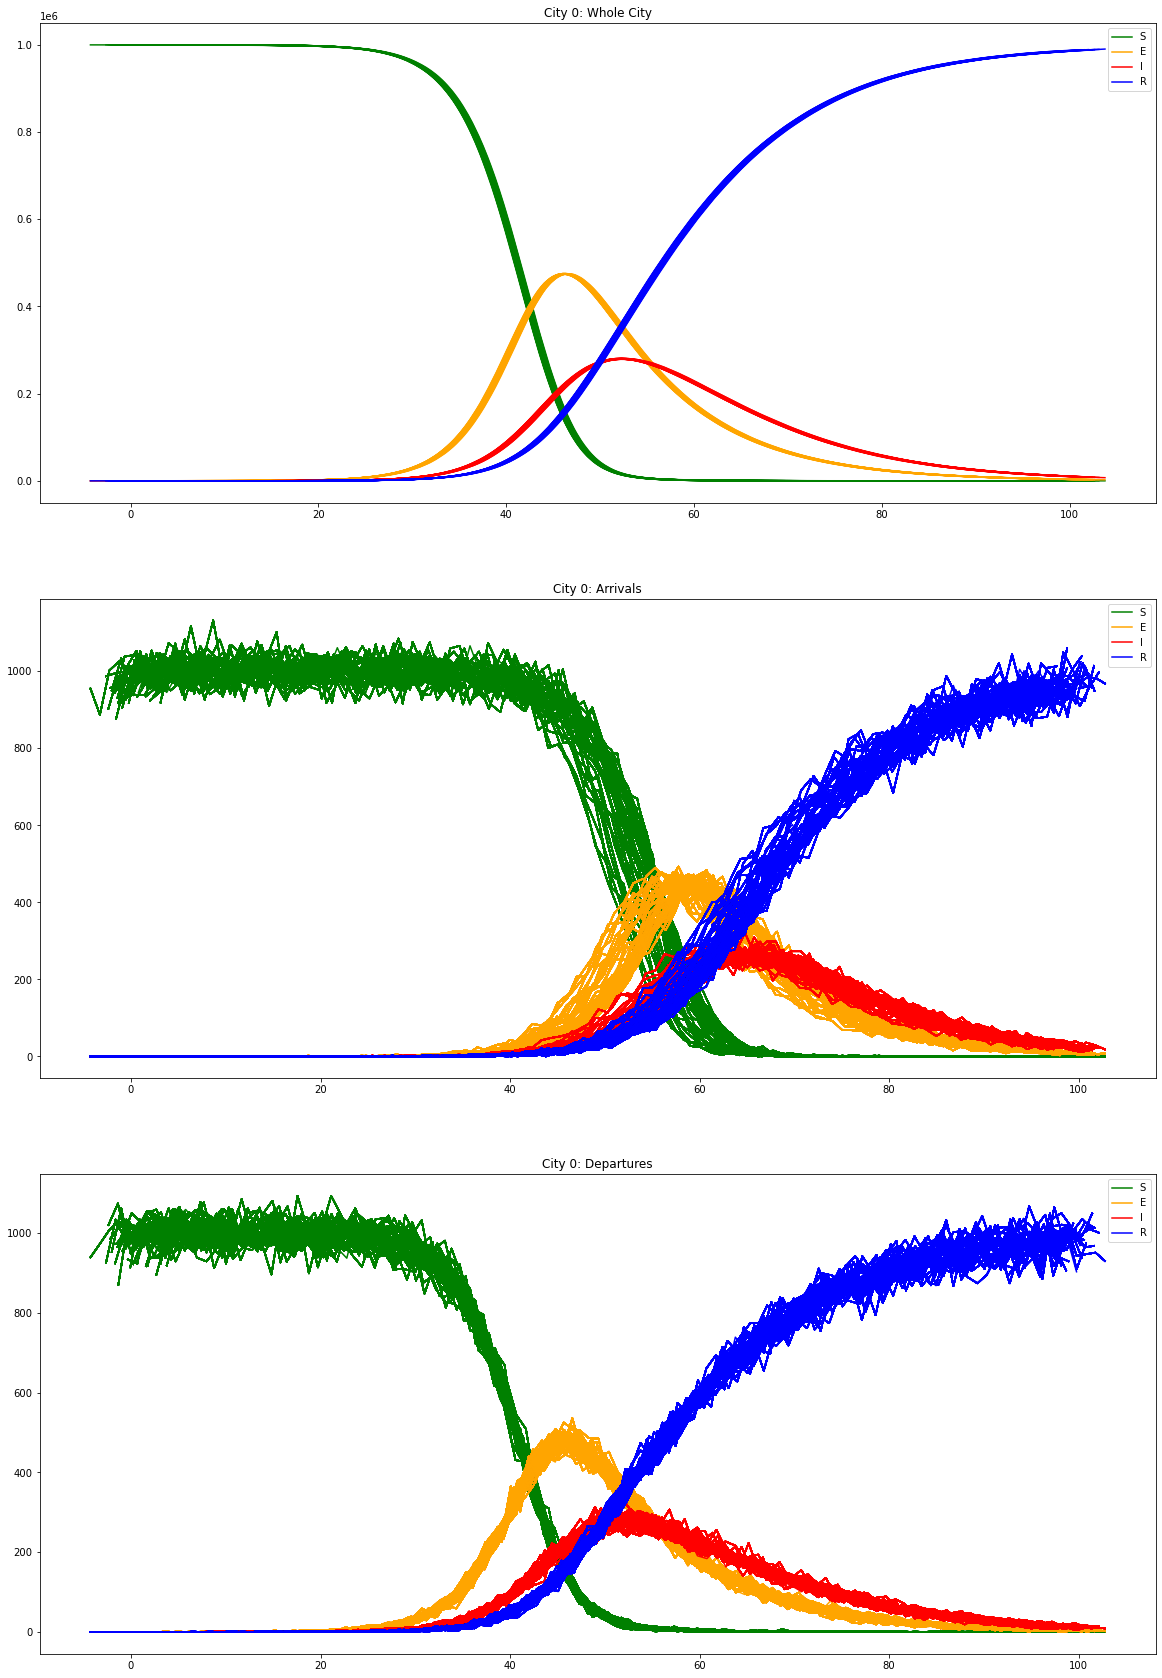

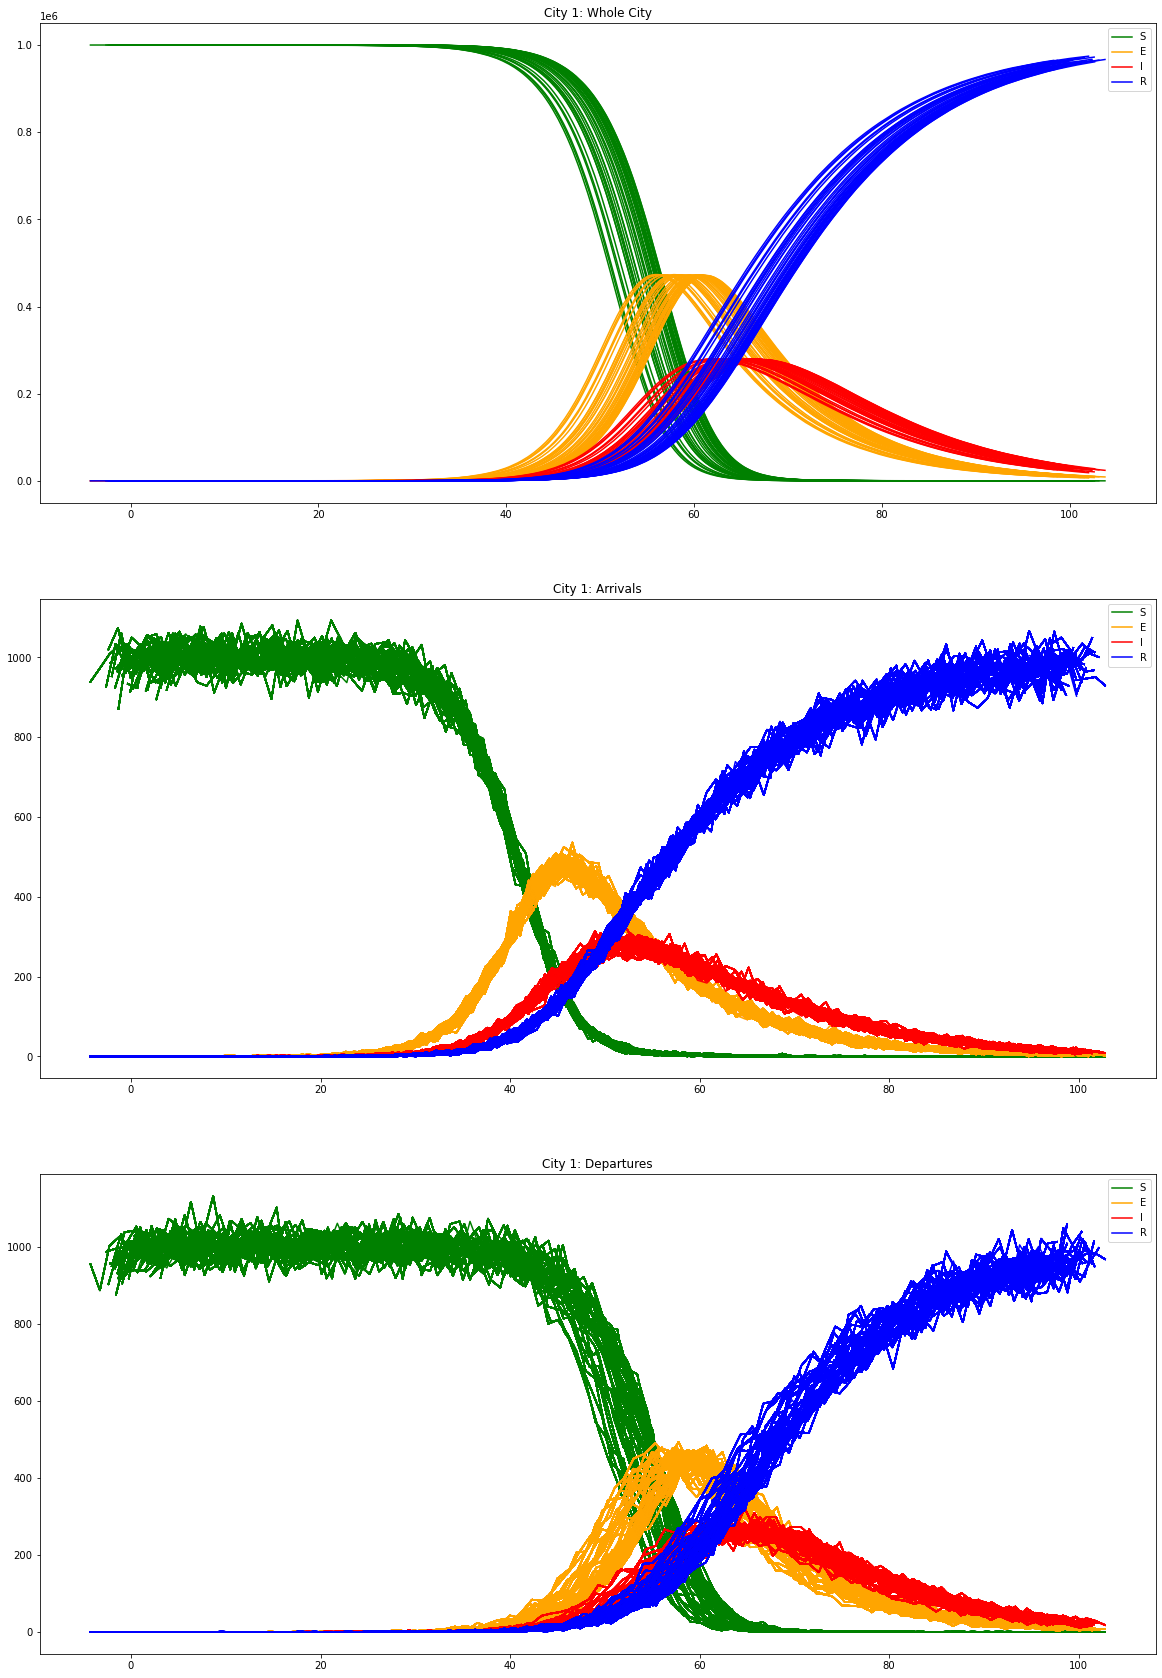

In [8]:
testnetwork.plot_sims(to_shift = True, separate_groups = False)

In [ ]:

class City:
    def __init__(self,
                 N0: int = 10**6,
                 compartments: str = 'SEIR',
                 n_groups: int = 1,
                 mixing_LR: Optional[float] = None):
        """
        """
        self.N0 = N0
        self.model_type = compartments
        self.compartments = [l for l in compartments]
        self.n_groups = n_groups
        self.mixing_LR = mixing_LR

    def reset_parameters(self, I0: int = 0, n_sims: int = 1, simulation_steps: int = 100):
        """
        Sets self.data to a dict of dicts, containing an array of zeros of size (n_sims, timesteps) for each compartment in the city
        The only values which aren't zero are the initial value of I which is I0 and the initial value of S which is N-I0
        The default value of I0 is the value set in the class initialization, but can be overridden
        """
        # if I0 is None:
        #     I0 = self.I0
        self.I0 = I0
        self.data = np.zeros((self.n_groups,len(self.compartments),n_sims, simulation_steps))
        self.arrivals = np.zeros((self.n_groups,len(self.compartments),n_sims, simulation_steps))
        self.departures = np.zeros((self.n_groups,len(self.compartments),n_sims, simulation_steps))
    
    def initial_conditions(self):
        raise ModuleNotFoundError
    
    def multiple_sims(self, delta_t: float, epidemic_time: Union[int,float], disease: Disease, I0: int = 0, n_sims: int = 100):
        self.n_sims = n_sims
        self.delta_t = delta_t
        self.epidemic_time = epidemic_time
        p_recovery = 1 - np.exp( - delta_t * disease.gamma)
        p_infectious = 1 - np.exp( - delta_t * disease.delta)
        timesteps = int(epidemic_time // delta_t)
        self.times = np.linspace(0, epidemic_time, timesteps+1)
        self.reset_parameters(I0, n_sims, timesteps+1)
        for timestep in tqdm(range(timesteps)):
            self.step_internal(disease.beta,
                      delta_t,
                      p_infectious,
                      p_recovery,
                      timestep)

    def step_internal(self,
                      beta:float,
                      delta_t: float,
                      p_infectious: float,
                      p_recovery: float,
                      simulation_step: int):
        new_S = {}
        new_E = {}
        new_I = {}
        new_R = {}
        N = {}

        for group in self.groups:
            N[group] = sum([self.data[group][compartment][:,simulation_step] for compartment in self.compartments])
        for i, group in enumerate(self.groups):
            modified_I = self.mixing_LR * self.data[group]['I'][:,simulation_step] + self.data[self.groups[not i]]['I'][:,simulation_step]
            modified_N = self.mixing_LR * N[group] + N[self.groups[not i]]
            exposure_rate = beta * modified_I / modified_N
            p_exposure = 1 - np.exp(- delta_t * exposure_rate)
            n_exposed = np.random.binomial(self.data[group]['S'][:,simulation_step], p_exposure)
            n_infectious = np.random.binomial(self.data[group]['E'][:,simulation_step], p_infectious)
            n_recovered = np.random.binomial(self.data[group]['I'][:,simulation_step], p_recovery)
            new_S[group] = self.data[group]['S'][:,simulation_step] - n_exposed
            new_E[group] = self.data[group]['E'][:,simulation_step] + n_exposed - n_infectious
            new_I[group] = self.data[group]['I'][:,simulation_step] + n_infectious - n_recovered
            new_R[group] = self.data[group]['R'][:,simulation_step] + n_recovered
            self.data[group]['S'][:,simulation_step+1] = new_S[group]
            self.data[group]['E'][:,simulation_step+1] = new_E[group]
            self.data[group]['I'][:,simulation_step+1] = new_I[group]
            self.data[group]['R'][:,simulation_step+1] = new_R[group]
        
        #Mixing between normal people and frequent fliers
        # for i, group in enumerate(self.groups):
        #     #TO DO: this line isn't quite right. Need to think a bit harder about which I and N to use
        #     exposure_rate = self.mixing_LR * beta * new_I[self.groups[not i]] / (N[self.groups[not i]])
            
        #     p_exposure = 1 - np.exp(- time_interval * exposure_rate)
        #     n_exposed = np.random.binomial(new_S[group], p_exposure)
        #     new_S[group] -= n_exposed
        #     new_E[group] += n_exposed

    def daily_flight_data(self, delta_t, moving_average = False):

        self.daily_arrivals = {}
        self.daily_departures = {}
        window = int(1/delta_t)
        for group in self.groups:
            self.daily_arrivals[group] = {}
            self.daily_departures[group] = {}
            for compartment in self.compartments:
                arrivals = self.arrivals[group][compartment]
                n_sims, simulation_steps = arrivals.shape
                self.daily_arrivals[group][compartment] = arrivals.reshape((n_sims, simulation_steps//window, window)).sum(axis = -1)
                #if moving_average
                    # arrivals = arrivals.lib.stride_tricks.as_strided((len(arrivals) - window + 1, window),(-1,1))
                departures = self.departures[group][compartment]
                self.daily_departures[group][compartment] = departures.reshape((n_sims, simulation_steps//window, window)).sum(axis = -1)

    def select_travellers_old(self, mixnumbers: Union[int,np.ndarray], n_sims: int, simulation_step: int):
        if isinstance(mixnumbers,int):
            mixnumbers = mixnumbers * np.ones(n_sims, dtype = np.int64)
        N = []
        for group in self.groups:
            N.append(sum([self.data[group][compartment][:,simulation_step+1] for compartment in self.compartments]))
        all_travellers = {'frequent_flyer': np.random.binomial(mixnumbers, self.p_ff)}
        all_travellers['normal'] = mixnumbers - all_travellers['frequent_flyer']
        travellers = np.zeros((2,4,n_sims), dtype = np.int64)
        for i,group in enumerate(self.groups):
            allocation_probs = []
            for compartment in self.compartments:
                allocation_probs.append(self.data[group][compartment][:,simulation_step+1] / N[i])
                if np.any(N == 0):
                    print('Warning: N == 0')
            allocation_probs = np.array(allocation_probs)
            # print(allocation_probs)
            travellers[i] = vectorized_multinomial(all_travellers[group], allocation_probs)
            
            #This bit is to make sure you never have more travellers than people
            valid = True
            for j, compartment in enumerate(self.compartments):
                if np.any(travellers[i,j] > self.data[group][compartment][:,simulation_step+1]):
                    valid = False
            while not valid:
                travellers[i] = vectorized_multinomial(all_travellers[group], allocation_probs)
                valid = True
                for j, compartment in enumerate(self.compartments):
                    if np.any(travellers[i,j] > self.data[group][compartment][:,simulation_step+1]):
                        valid = False
        return travellers

    def select_travellers(self, daily_mixnumber: int, n_sims: int, simulation_step: int, delta_t: float):
        "Selects travellers based on a constant rate per person. This means number of travellers isn't preserved so the rate is modified to provide a force that pushes things back to the baseline population"
        N = []
        fractions = [1 - self.p_ff, self.p_ff]
        for group in self.groups:
            N.append(sum([self.data[group][compartment][:,simulation_step+1] for compartment in self.compartments]))
        
        travellers = np.zeros((2,4,n_sims), dtype = np.int64)
        for i,group in enumerate(self.groups):
            modified_mixnumber = daily_mixnumber * N[i] / self.N0[group]
            p_travel = 1 - np.exp(- delta_t * modified_mixnumber * fractions[i] / N[i])
            for j,compartment in enumerate(self.compartments):
                travellers[i,j] = np.random.binomial(self.data[group][compartment][:,simulation_step+1], p_travel)
        return travellers
    
    def make_data_array(self):
        "Converts the dictionary of dictionary of data for each group and compartment into a single big array to ease data manipulation"
        include_flight_data = 'arrivals' in dir(self)
        self.data_array: np.ndarray = np.zeros((2,4,self.n_sims,len(self.times)),dtype = np.int64)
        if include_flight_data:
            self.arrivals_array: np.ndarray = np.zeros((2,4,self.n_sims,len(self.times)),dtype = np.int64)
            self.departures_array: np.ndarray = np.zeros((2,4,self.n_sims,len(self.times)),dtype = np.int64)
            n_days = self.daily_arrivals['normal']['I'].shape[-1]
            self.daily_arrivals_array: np.ndarray = np.zeros((2,4,self.n_sims, n_days),dtype = np.int64)
            self.daily_departures_array: np.ndarray = np.zeros((2,4,self.n_sims, n_days),dtype = np.int64)
        for i, group in enumerate(self.groups):
            for j, compartment in enumerate(self.compartments):
                self.data_array[i,j] = self.data[group][compartment]
                if include_flight_data:
                    self.arrivals_array[i,j] = self.arrivals[group][compartment]
                    self.departures_array[i,j] = self.departures[group][compartment]
                    self.daily_arrivals_array[i,j] = self.daily_arrivals[group][compartment]
                    self.daily_departures_array[i,j] = self.daily_departures[group][compartment]

    def plot_sims(self,
                  times: Optional[np.ndarray] = None,
                  cityname: Union[int,str] = 0, 
                  shift_index: Optional[np.ndarray] = None,
                  separate_groups: bool = False):
        include_flight_data = 'arrivals' in dir(self)
        subplots = 2 if separate_groups else 1
        if include_flight_data:
            fig, axs = plt.subplots(3,subplots, figsize = (20,30))
            axs = np.array(axs)
        else:
            fig, axs = plt.subplots(1,subplots, figsize = (20,10))
            axs = np.expand_dims(np.array(axs),0)
        if times is None:
            times = self.times
        if shift_index is None:
            shift = np.zeros((self.n_sims,1))
        else:
            shift = times[shift_index].reshape((self.n_sims,1))
        # assert shift.shape == (self.n_sims,1), "Wrong shift shape"
        days = np.array(range(int(max(times))), dtype = np.float64)
        
        times = times - shift + shift.mean()
        days = days - shift + shift.mean()
        cols = ['green', 'orange', 'red', 'blue']
        labels = ['Whole City', 'Arrivals', 'Departures']
        if separate_groups:
            for i, group in enumerate(self.groups):
                for j,compartment in tqdm(enumerate(self.compartments)):
                    axs[0,i].plot(times[0],
                                self.data[group][compartment][0],
                                label = compartment,
                                color = cols[j])
                    if include_flight_data:
                        axs[1,i].plot(days[0],  
                                    self.daily_arrivals[group][compartment][0],
                                    label = compartment,
                                    color = cols[j])
                        axs[2,i].plot(days[0],
                                    self.daily_departures[group][compartment][0],
                                    label = compartment,
                                    color = cols[j])
                    for k,datum in enumerate(self.data[group][compartment][1:]):
                        axs[0,i].plot(times[k+1], datum, color = cols[j])
                    if include_flight_data:
                        for k, (arrival, departure) in enumerate(zip(self.daily_arrivals[group][compartment][1:],self.daily_departures[group][compartment][1:])):
                            axs[1,i].plot(days[k+1], arrival, color = cols[j])
                            axs[2,i].plot(days[k+1], departure, color = cols[j])
                num_subplots = axs.shape[0]
                for j in range(num_subplots):
                    axs[j,i].legend()
                    axs[j,i].set_title(f"City {cityname}, {group}: {labels[j]}")
        else:
            for j, compartment in tqdm(enumerate(self.compartments)):
                axs[0].plot(times[0],
                            self.data_array[:,j,0].sum(axis = 0),
                            label = compartment,
                            color = cols[j])
                if include_flight_data:
                    axs[1].plot(days[0],
                                self.daily_arrivals_array[:,j,0].sum(axis = 0),
                                label = compartment,
                                color = cols[j])
                    axs[2].plot(days[0],
                                self.daily_departures_array[:,j,0].sum(axis = 0),
                                label = compartment,
                                color = cols[j])
                for k,datum in enumerate(self.data_array[:,j,1:].sum(axis = 0)):
                    axs[0].plot(times[k+1], datum, color = cols[j])
                    if include_flight_data:
                        for k, (arrival, departure) in enumerate(zip(self.daily_arrivals_array[:,j,1:].sum(axis = 0),self.daily_departures_array[:,j,1:].sum(axis = 0))):
                            axs[1].plot(days[k+1], arrival, color = cols[j])
                            axs[2].plot(days[k+1], departure, color = cols[j])
            num_subplots = axs.shape[0]
            for j in range(num_subplots):
                axs[j].legend()
                axs[j].set_title(f"City {cityname}: {labels[j]}")
        # else:
        #     for i, group in enumerate(self.groups):
        #         for j,compartment in enumerate(self.compartments):
        #             axs[i].plot(x_axis, self.data[group][compartment][0], label = compartment, color = cols[j])
        #             for datum in tqdm(self.data[group][compartment][1:]):
        #                 axs[i].plot(x_axis, datum, color = cols[j])
        #         axs[i].legend()
        #         axs[i].set_title(f"City {cityname}, {group}")
        fig.show()
    
    def infections_at_time(self, time_indexes: Optional[np.ndarray] = None, time: Optional[np.ndarray] = None, included_compartments: str = 'EIR'):
        """
        Returns the number of normal, infectious, and total people who have left the susceptible compartment by time t
        times: size (n_sims) the (different) time at which to evaluate number who have been exposed for each sim
        """
        assert (time is not None) != (time_indexes is not None), "Exactly one of time_indexes and times should be specified"
        if time_indexes is None:
            assert time is not None
            time_indexes = self.times.searchsorted(time)
        assert len(time_indexes) == self.n_sims, "len(times) must be n_sims"
        out = {}
        values = np.zeros((self.n_sims,2,4))
        to_include = [l for l in included_compartments]
        for i,group in enumerate(self.groups):
            out[group] = np.zeros(self.n_sims)
            for j, compartment in enumerate(self.compartments):
                # values[:,i,j] = self.data[group][compartment][np.array(range(self.n_sims)),time_indexes]
                if compartment in to_include:
                    out[group] += self.data[group][compartment][np.array(range(self.n_sims)),time_indexes]
            # out[group] = values[:,i].sum(axis = -1) - values[:,i,0]
            assert out[group].shape == (self.n_sims,), "Logical Error Somewhere!"
        out['total'] = sum([out[group] for group in self.groups])
        return out

